# Data Preprocessing

In [2]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

import numpy as np

from shapely.geometry import shape
from shapely.ops import transform
from pyproj import Transformer
import json
import statsmodels.api as sm


#Declare Major Party Colors
party_colors = {
    'IND': '#5555FF',
    'PML': '#3EB932',
    'PMLN': '#004400',
    'PPP': '#F02D2D',
    'MQM': '#6F2A2A',
    'PTI': '#22BB5F',
    'MQM-P': '#777777'
}

#Opens Excel Document
df = pd.read_excel("./data/DawnResults/Pak_Election_Voting_Results_Dawn_API_Combine.xlsx")

#Convert Proper Columns to Numbers
df['obtained_votes'] = pd.to_numeric(df['obtained_votes'],errors='coerce')
df['pop'] = pd.to_numeric(df['pop'],errors='coerce')
df['no_of_polling_stations'] = pd.to_numeric(df['no_of_polling_stations'],errors='coerce')
df['male'] = pd.to_numeric(df['male'],errors='coerce')
df['female'] = pd.to_numeric(df['female'],errors='coerce')
df['total'] = pd.to_numeric(df['total'],errors='coerce')
df['YEAR_ELECTION'] = pd.to_numeric(df['YEAR_ELECTION'],errors='coerce')


#Identifies if column data is there and if there is enough data to generate column
femaleNotExist = df['female'].isna() | df['female'] == 0
maleNotExist = df['male'].isna() | df['male'] == 0
totalNotExist = df['total'].isna() | df['total'] == 0

possibleGeneration = femaleNotExist ^ maleNotExist ^ totalNotExist

#Attempts to populate missing population cells with data missing if possible
df.loc[femaleNotExist & possibleGeneration, 'female'] = df['total'] - df['male']
df.loc[maleNotExist & possibleGeneration, 'male'] = df['total'] - df['female']
df.loc[totalNotExist & possibleGeneration, 'total'] = df['male'] + df['female']

#Function Returns the Area of a Province using 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def geoStringToArea(geoString):
    
    try:
        geoJSON = json.loads(geoString)
    except:
        return float('nan')
    
    return transform(transformer.transform, shape(geoJSON)).area / 1000000

def geoStringToCenterX(geoString):
    
    try:
        geoJSON = json.loads(geoString)
    except:
        return float('nan')
    
    center = shape(geoJSON).centroid

    return center.x

def geoStringToCenterY(geoString):
    
    try:
        geoJSON = json.loads(geoString)
    except:
        return float('nan')
    
    center =  shape(geoJSON).centroid

    return center.y

#Creates New Data Categories
df.loc[ possibleGeneration, 'femaleRatio'] = df['female'] / df['total']
df['area'] = df['geom'].apply(geoStringToArea)
df['pop_density'] = df['pop'] / df['area']

df['centerX'] = df['geom'].apply(geoStringToCenterX)
df['centerY'] = df['geom'].apply(geoStringToCenterY)

#Grabs The Parties to be Analyzed
largeParties = df['party_affilation'].value_counts().head(7).keys().array

#Merge PTI-Backed and PTI
df.loc[df['party_affilation'] == 'PTI-Backed','party_affilation'] = 'PTI'

df.to_excel('./data/DawnResults/Pak_Election_Voting_Results_Dawn_API_Combine.xlsx', index=False)

df = df[df['party_affilation'].isin(party_colors)]
df = df.dropna()


# The Woman Vote

/home/omniladder/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/omniladder/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 19.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/omniladder/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 77.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/omniladder/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/omniladder/.local/lib/python3.10/site-packages/seaborn/cat

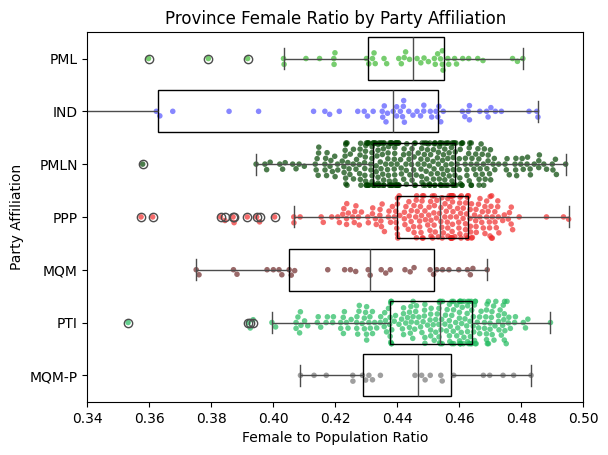

In [3]:

partyAndGenderData = df.filter(items = ['party_affilation', 'femaleRatio'])
#print('Hello' in largeParties)
partyAndGenderData = partyAndGenderData[partyAndGenderData['party_affilation'].isin(largeParties)]
#plt.scatter()
#partyAndGenderData['femaleRatio'] = StandardScaler().fit_transform(partyAndGenderData[['femaleRatio']])
#print(largeParties)

swarm = sb.swarmplot(x='femaleRatio', y="party_affilation", data=partyAndGenderData, hue='party_affilation', size=4, zorder=1, palette=party_colors, alpha=.7) 
box = sb.boxplot(x='femaleRatio', y='party_affilation', data=partyAndGenderData,linewidth=1, boxprops=dict(facecolor='none', edgecolor='black'), zorder=2)
plt.xlim(left=.34, right=.5)

swarm.set_xlabel('Female to Population Ratio')  # Label for the x-axis
swarm.set_ylabel('Party Affiliation')  # Label for the y-axis
swarm.set_title('Province Female Ratio by Party Affiliation')  # Title of the plot

plt.savefig('femaleProport.png', format='png', dpi=300)
plt.show()
#print((partyAndGenderData))

# Population Density

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4756
Date:                Wed, 06 Nov 2024   Prob (F-statistic):              0.491
Time:                        16:51:11   Log-Likelihood:                -9074.0
No. Observations:                 938   AIC:                         1.815e+04
Df Residuals:                     936   BIC:                         1.816e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3067.1682    430.545      7.124      0.0

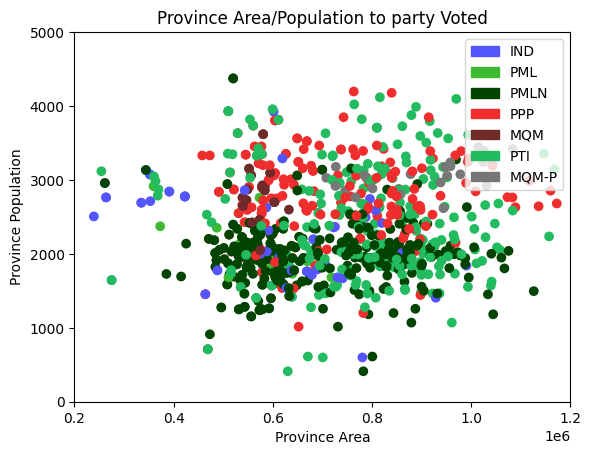

In [7]:
popDensity = df.filter(items = ['party_affilation', 'pop', 'area'])

popScaler = StandardScaler()
areaScaler = StandardScaler()






X2 = sm.add_constant(popDensity['pop'])
est = sm.OLS(popDensity['area'], X2)
est2 = est.fit()
print(est2.summary())

colors = popDensity['party_affilation'].map(party_colors)
scaled_pop = popScaler.fit_transform(popDensity[['pop']])
scaled_area = areaScaler.fit_transform(popDensity[['area']])

#Grabs SVC and Draws Contour
svc = SVC(kernel='rbf', tol=1e-5, C=.45)
dummy = DummyClassifier(strategy='most_frequent')

# Fit the model on the training data
dummy.fit(np.column_stack((scaled_pop, scaled_area)), popDensity['party_affilation'])

# Make predictions on the test set
y_pred = dummy.predict(np.column_stack((scaled_pop, scaled_area)))

# Calculate accuracy
accuracy = accuracy_score(popDensity['party_affilation'], y_pred)
print("Dummy Accuracy", accuracy)

svc.fit(np.column_stack((scaled_pop, scaled_area)), popDensity['party_affilation'])



# Make predictions on the test data
y_pred = svc.predict(np.column_stack((scaled_pop, scaled_area)))

# Calculate the accuracy
accuracy = accuracy_score(popDensity['party_affilation'], y_pred)
print("Accuracy:",accuracy)

plt.scatter(popDensity['pop'], popDensity['area'] , c=colors)
#plt.scatter(popDensity['pop'], popDensity['area'])

plt.title("Province Area/Population to party Voted")

plt.ylabel("Province Population")
plt.xlabel("Province Area")

party_patches = [
    mpatches.Patch(color=color, label=party) 
    for party, color in party_colors.items()
]

plt.legend(handles=party_patches,loc=1)

plt.xlim(left=.2e6, right=1.2e6)
plt.ylim(bottom=0, top=5000)

#plt.xlim(left=-1, right=1)
#plt.ylim(bottom=-1, top=1)

plt.savefig('popDensity.png', format='png', dpi=300)

plt.show()



# Geographical Dominance of Parties

Dummy Accuracy 0.35287846481876334
Accuracy: 0.0


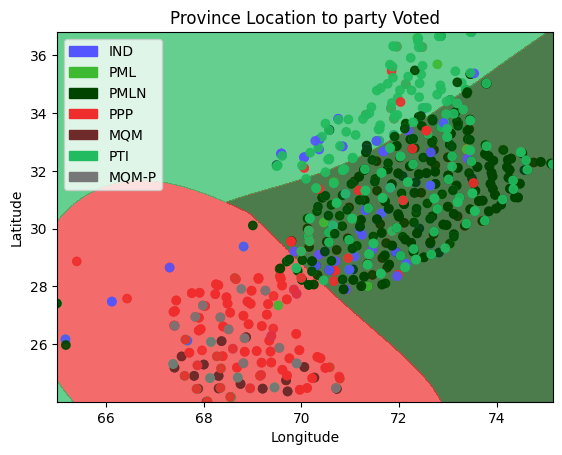

In [ ]:

locationParties = df.filter(['centerX', 'centerY', 'party_affilation'])

popScaler = StandardScaler()
areaScaler = StandardScaler()

colors = locationParties['party_affilation'].map(party_colors)
scaled_pop = popScaler.fit_transform(locationParties[['centerX']])
scaled_area = areaScaler.fit_transform(locationParties[['centerY']])

#Grabs SVC and Draws Contour
svc = SVC(kernel='rbf', C=0.05)
dummy = DummyClassifier(strategy='most_frequent')


plt.title("Province Location to party Voted")

plt.ylabel("Latitude")
plt.xlabel("Longitude")

# Encode categorical labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(locationParties['party_affilation'])

# Fit the model on the training data
dummy.fit(np.column_stack((scaled_pop, scaled_area)), locationParties['party_affilation'])

# Make predictions on the test set
y_pred = dummy.predict(np.column_stack((scaled_pop, scaled_area)))

# Calculate accuracy
accuracy = accuracy_score(locationParties['party_affilation'], y_pred)
print("Dummy Accuracy", accuracy)

# Calculate the accuracy


svc.fit(np.column_stack((scaled_pop, scaled_area)), y_encoded)


# Make predictions on the test data
y_pred = svc.predict(np.column_stack((scaled_pop, scaled_area)))
accuracy = accuracy_score(y_encoded, y_pred)
print("Accuracy:",accuracy)

xx, yy = np.meshgrid(np.linspace(scaled_pop.min(), scaled_pop.max(), 1000), np.linspace(scaled_area.min(), scaled_area.max(), 1000))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

xx_original = popScaler.inverse_transform(xx.ravel().reshape(-1,1))  # Transform back to original scale
yy_original = areaScaler.inverse_transform(yy.ravel().reshape(-1,1))


cmap = ListedColormap([party_colors[party] for party in label_encoder.classes_])
levels = np.arange(len(label_encoder.classes_) + 1) - 0.5

#Z_colors = np.vectorize(lambda x: party_colors[label_encoder.inverse_transform(x)])(Z)

plt.contourf(xx_original.reshape(xx.shape), yy_original.reshape(yy.shape), Z.reshape(xx.shape),cmap=cmap, levels=levels , alpha = .7)

party_patches = [
    mpatches.Patch(color=color, label=party) 
    for party, color in party_colors.items()
]

plt.legend(handles=party_patches,loc='best')

plt.scatter(locationParties['centerX'], locationParties['centerY'], label=locationParties['party_affilation'], c=locationParties['party_affilation'].map(party_colors),alpha=.9)

plt.savefig('locationGraph.png', format='png', dpi=300)

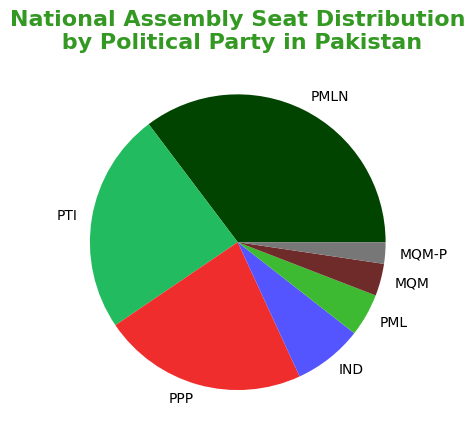

In [122]:
#values, counts = np.unique(pakiParties, return_counts = True)


partyOccurences = df['party_affilation'].value_counts()


# Generate colors for the pie chart based on the order of parties in `partyOccurences`
colors = [party_colors[party] for party in partyOccurences.index]

plt.pie(partyOccurences.values, labels=partyOccurences.keys(), colors=colors)
plt.title('National Assembly Seat Distribution\n by Political Party in Pakistan', fontsize=16, fontweight='bold', color='#339922')

#plt.legend(bbox_to_anchor=(1,1.025), loc="upper left")


plt.savefig('vote_distribution.png', format='png', dpi=300)
plt.show()
